## Preparació

In [1]:
# Paquets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
# Dades

path = 'https://storage.googleapis.com/datascience-290812/competitive-data-science-predict-future-sales/'
#path = './competitive-data-science-predict-future-sales/'

sales = pd.read_csv(path + 'sales_train.csv')
items = pd.read_csv(path + 'items.csv')
categories = pd.read_csv(path + 'item_categories.csv')
test = pd.read_csv(path + 'test.csv')

## Preprocessament

In [3]:
# Dividim les categories en subcategories

def category_name2(s):
    # Torna la segona part del nom de la categoria, quan és possible
    s = s.split(' - ')
    if len(s)==2:
        return s[1]
    else:
        return s[0]

categories['cat_name1'] = categories.iloc[:,0].apply(lambda s: s.split(' - ')[0])
categories['cat_name2'] = categories.iloc[:,0].apply(category_name2)

In [4]:
# Neteja de dades

# Outliers
sales = sales.loc[sales.item_price<10000,:]
sales = sales.loc[sales.item_cnt_day<1500,:]

# Preus negatius
sales = sales.loc[sales.item_price>0,:]

# Devolucions
sales = sales.loc[sales.item_cnt_day > 0,:]

In [5]:
# Agregació de ventes per mes

sales_month = sales\
            .groupby(['date_block_num','item_id','shop_id'], as_index = False)\
            .agg({'item_cnt_day':'sum'})\
            .rename(columns= {'item_cnt_day':'item_cnt'})

In [6]:
sales_month['item_cnt'] = sales_month['item_cnt'].clip(0,20)

In [7]:
# Creem el conjunt d'entrenament

train = test.iloc[:,1:].copy()
train['date_block_num'] = 0

for d in range(1,34):
    df = test.iloc[:,1:].copy()
    df['date_block_num'] = d
    train = train.append(df)

# Dies del mes
month_days = [31,28,31,30,31,30,31,31,30,31,30,31]
train['month_days'] = train['date_block_num'].apply(lambda x: month_days[x%12])

# Categoria
train = pd.merge(train, items[['item_id','item_category_id']], how='left', on='item_id')

# Subcategories
train = pd.merge(train, categories[['item_category_id','cat_name1','cat_name2']], how='left', on='item_category_id')

# Ventes
train = pd.merge(train, sales_month, how='left', on=['item_id','shop_id','date_block_num'])
train.fillna(value=0, inplace=True)

# Interaction feature
train['itemshop_id'] = train['item_id'] * 100 + train['shop_id']

# Indiquem si l'atribut es troba a sales
item_sales = sales_month.item_id.unique()
train['item_in_sales'] = train['item_id'].isin(item_sales)

shop_sales = sales_month.shop_id.unique()
train['shop_in_sales'] = train['shop_id'].isin(shop_sales)

In [8]:
# Afegim atributs a test

test['month_days'] = 30
test['date_block_num'] = 34

test = pd.merge(test, items[['item_id','item_category_id']], how='left', on='item_id')
test = pd.merge(test, categories[['item_category_id','cat_name1','cat_name2']], how='left', on='item_category_id')

test['itemshop_id'] = test['item_id'] * 100 + test['shop_id']

test['item_in_sales'] = test['item_id'].isin(item_sales)
test['shop_in_sales'] = test['shop_id'].isin(shop_sales)

In [9]:
CATEGORICAL_COLUMNS = ['itemshop_id','item_id','shop_id','item_category_id','cat_name1','cat_name2']

In [10]:
# Lag features


for column in ['itemshop_id','item_id','shop_id']:
    cnt = train\
            .groupby(['date_block_num', column], as_index = False)\
            .agg({'item_cnt':'sum'})

    for i in [1,2,3,6,12]:
        tmp = cnt.copy()
        tmp['date_block_num'] = tmp['date_block_num'] + i
        tmp = tmp.rename(columns={'item_cnt': column + '_lag_' + str(i)})
        train = pd.merge(train, tmp, how='left', on=['date_block_num', column])
        test = pd.merge(test, tmp, how='left', on=['date_block_num', column])

train.fillna(value=0, inplace=True)

In [11]:
del categories, items, sales_month

In [12]:
# Finestra temporal

WINDOW = 12 

# Mesos d'entrenament
TEST_MONTH = 34
EVAL_MONTH = TEST_MONTH - 1
FIRST_MONTH = EVAL_MONTH - WINDOW

# Datasets
X_train = train.loc[(train['date_block_num']<EVAL_MONTH)&(train['date_block_num']>=(EVAL_MONTH - WINDOW)),:]
X_eval = train.loc[train['date_block_num']==EVAL_MONTH,:]

In [13]:
# Frequency encoding
for column in CATEGORICAL_COLUMNS:
    cnt = X_train.groupby([column], as_index=False)\
                        .agg({'item_cnt':'sum'})\
                        .rename(columns={'item_cnt': (column + '_freq')})

    X_train = pd.merge(X_train, cnt, how='left', on=column)
    X_eval = pd.merge(X_eval, cnt, how='left', on=column)

In [14]:
# Eliminem atributs categòrics
X_train.drop(CATEGORICAL_COLUMNS, 1, inplace=True)
X_eval.drop(CATEGORICAL_COLUMNS, 1, inplace=True)

# Separem columna objectiu
y_train = X_train.pop('item_cnt').clip(0,20)
y_eval = X_eval.pop('item_cnt').clip(0,20)

In [15]:
X_train.head()

,date_block_num,month_days,item_in_sales,shop_in_sales,itemshop_id_lag_1,itemshop_id_lag_2,itemshop_id_lag_3,itemshop_id_lag_6,itemshop_id_lag_12,item_id_lag_1,item_id_lag_2,item_id_lag_3,item_id_lag_6,item_id_lag_12,shop_id_lag_1,shop_id_lag_2,shop_id_lag_3,shop_id_lag_6,shop_id_lag_12,itemshop_id_freq,item_id_freq,shop_id_freq,item_category_id_freq,cat_name1_freq,cat_name2_freq
0,21,31,True,True,1.0,0.0,0.0,0.0,0.0,183.0,0.0,0.0,0.0,0.0,743.0,898.0,765.0,523.0,442.0,12.0,933.0,11069.0,42528.0,152282.0,44545.0
1,21,31,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,743.0,898.0,765.0,523.0,442.0,0.0,0.0,11069.0,74229.0,83721.0,74229.0
2,21,31,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,743.0,898.0,765.0,523.0,442.0,9.0,446.0,11069.0,42528.0,152282.0,44545.0
3,21,31,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,743.0,898.0,765.0,523.0,442.0,1.0,112.0,11069.0,36470.0,152282.0,40679.0
4,21,31,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,743.0,898.0,765.0,523.0,442.0,0.0,0.0,11069.0,51230.0,152282.0,60723.0


## Model

In [ ]:
# Optimització dels hiperparàmetres

parameters = {'n_estimators':[10], 'max_depth':[8,10,12]}
model = XGBRegressor()
search = GridSearchCV(model, parameters, cv=3, return_train_score=False)
search.fit(X_train, y_train)

resultat = pd.DataFrame(search.cv_results_)
resultat.sort_values(by='mean_test_score', ascending=True)

In [16]:
# Entrenament

model = XGBRegressor(n_estimators= 30, max_depth=8, objective='reg:squarederror')
model.fit(X_train, y_train, eval_metric="rmse",
          eval_set=[(X_train, y_train), (X_eval, y_eval)],
          early_stopping_rounds = 5)

[0]	validation_0-rmse:1.11558	validation_1-rmse:1.075
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.04762	validation_1-rmse:1.04114
[2]	validation_0-rmse:0.996444	validation_1-rmse:1.01698
[3]	validation_0-rmse:0.94526	validation_1-rmse:0.994298
[4]	validation_0-rmse:0.91036	validation_1-rmse:0.978266
[5]	validation_0-rmse:0.883256	validation_1-rmse:0.964262
[6]	validation_0-rmse:0.834678	validation_1-rmse:0.95366
[7]	validation_0-rmse:0.811973	validation_1-rmse:0.944178
[8]	validation_0-rmse:0.792677	validation_1-rmse:0.937345
[9]	validation_0-rmse:0.768398	validation_1-rmse:0.93235
[10]	validation_0-rmse:0.755767	validation_1-rmse:0.929128
[11]	validation_0-rmse:0.743981	validation_1-rmse:0.924964
[12]	validation_0-rmse:0.733879	validation_1-rmse:0.92277
[13]	validation_0-rmse:0.722819	validation_1-rmse:0.921682
[14]	validation_0-rmse:0.714454	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=30,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [17]:
# RMSE avaluació

np.sqrt(mean_squared_error(model.predict(X_eval), y_eval))

0.9172918276364012

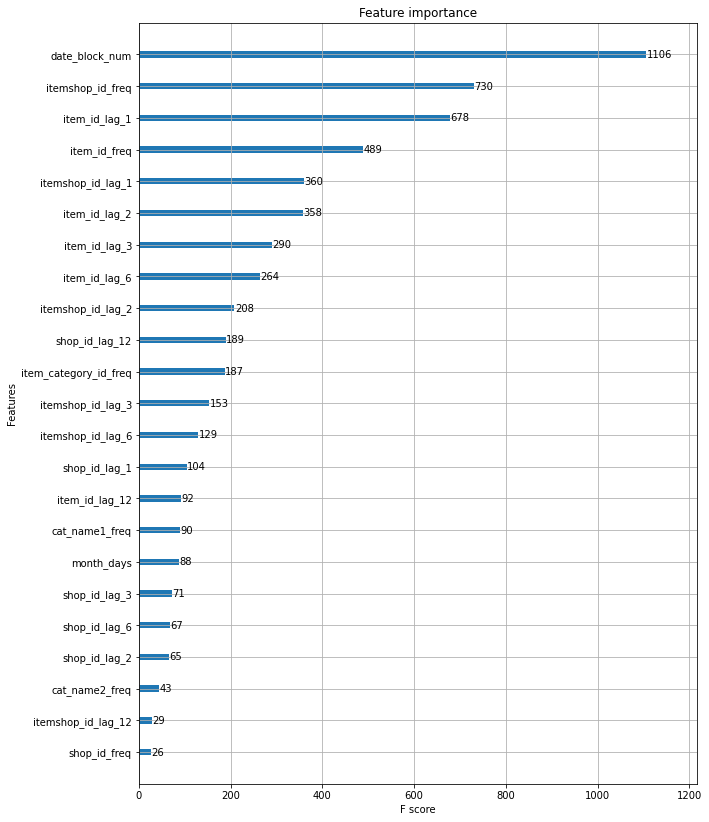

In [18]:
# Importància dels atributs

fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(booster=model, ax=ax)

In [19]:
del X_train, X_eval, y_train, y_eval, model

## Predicció

In [20]:
# Dades d'entrenament

train = train.loc[train['date_block_num']>=(TEST_MONTH - WINDOW),:]

In [21]:
# Preprocessament

for attrib in CATEGORICAL_COLUMNS:
    cnt = train.groupby([attrib], as_index=False)\
                        .agg({'item_cnt':'sum'})\
                        .rename(columns={'item_cnt': (attrib + '_freq')})

    train = pd.merge(train, cnt, how='left', on=attrib)
    test = pd.merge(test, cnt, how='left', on=attrib)

In [22]:
train.drop(CATEGORICAL_COLUMNS, 1, inplace=True)
test.drop(CATEGORICAL_COLUMNS, 1, inplace=True)

y = train.pop('item_cnt').clip(0,20)

In [23]:
train.head(2)

,date_block_num,month_days,item_in_sales,shop_in_sales,itemshop_id_lag_1,itemshop_id_lag_2,itemshop_id_lag_3,itemshop_id_lag_6,itemshop_id_lag_12,item_id_lag_1,item_id_lag_2,item_id_lag_3,item_id_lag_6,item_id_lag_12,shop_id_lag_1,shop_id_lag_2,shop_id_lag_3,shop_id_lag_6,shop_id_lag_12,itemshop_id_freq,item_id_freq,shop_id_freq,item_category_id_freq,cat_name1_freq,cat_name2_freq
0,22,30,True,True,0.0,1.0,0.0,0.0,0.0,52.0,183.0,0.0,0.0,0.0,751.0,743.0,898.0,615.0,506.0,12.0,906.0,11326.0,41793.0,154064.0,43678.0
1,22,30,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,751.0,743.0,898.0,615.0,506.0,0.0,0.0,11326.0,73860.0,83578.0,73860.0


In [24]:
# Entrenament

model = XGBRegressor(max_depth=8, n_estimators= 20, objective='reg:squarederror')\
                    .fit(train, y, eval_metric="rmse", eval_set=[(train,y)], early_stopping_rounds = 5)

[0]	validation_0-rmse:1.11122
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.04311
[2]	validation_0-rmse:0.990143
[3]	validation_0-rmse:0.94158
[4]	validation_0-rmse:0.905596
[5]	validation_0-rmse:0.876554
[6]	validation_0-rmse:0.830631
[7]	validation_0-rmse:0.808578
[8]	validation_0-rmse:0.789703
[9]	validation_0-rmse:0.76562
[10]	validation_0-rmse:0.750754
[11]	validation_0-rmse:0.737288
[12]	validation_0-rmse:0.726634
[13]	validation_0-rmse:0.714895
[14]	validation_0-rmse:0.706662
[15]	validation_0-rmse:0.699399
[16]	validation_0-rmse:0.693309
[17]	validation_0-rmse:0.687622
[18]	validation_0-rmse:0.683193
[19]	validation_0-rmse:0.67759


In [25]:
# Predicció

y_pred = model.predict(test[train.columns]).clip(0,20)
submission = pd.DataFrame({'ID':test['ID'], 'item_cnt_month': y_pred})

In [26]:
# Colab export

from google.colab import files

submission.to_csv('submission.csv', index = False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test score: 1.06137